In [2]:
import joblib
import pandas as pd
import pingouin as pg
import numpy as np
import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


plt.rcParams['font.family'] = 'Malgun Gothic'     # 한글 폰트 설정 (윈도우용)
plt.rcParams['axes.unicode_minus'] = False  


csv_path = 'superhost.csv'    # 여기에 absolute path
# CSV 읽기
df = pd.read_csv(
    csv_path,
    header=0,        # 첫 줄을 컬럼명으로 사용
    index_col='id',  # 인덱스 컬럼으로 id 지정
    encoding='utf-8-sig'
)

In [ ]:
# 슈퍼호스트여부 판별 예측 모델링(파이프라인)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# === 1. 타겟 및 피처 정의 ===
TARGET = 'host_is_superhost'
strategy_cols = [
    'amenities_cnt', 'availability_365', 'price', 'host_about_length_group',
    'room_type','name_length_group', 'description_length_group',
    'host_has_profile_pic', 'host_response_time_score','type_amenity_score',
    'common_amenity_score', 'host_acceptance_rate_score', 'host_identity_verified',
    'is_long_term', 'accommodates'
]

X = df[strategy_cols]
y = df[TARGET].astype(int)

# === 2. 전처리 준비 ===
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', drop=None), categorical_cols)
], remainder='passthrough')

# === 3. 파이프라인 구성 ===
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=1000,
        max_depth=30,
        min_samples_split=15,
        min_samples_leaf=10,
        random_state=42,
        class_weight='balanced'
    ))
])

# === 4. 학습 및 평가용 데이터 분할 ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === 5. 모델 학습 ===
pipeline.fit(X_train, y_train)

# === 6. 성능 평가 ===
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("\n=== [랜덤포레스트 전략모델 성능 평가] ===")
print(classification_report(y_test, y_pred))
print("AUC:", round(roc_auc_score(y_test, y_proba), 4))

# === 7. 전체 데이터 예측 확률 (상위 확률 샘플 찾기) ===
full_proba = pipeline.predict_proba(X)[:, 1]
top_indices = np.argsort(full_proba)[-10:][::-1]  # 상위 10개 인덱스

print("\n=== [전체 데이터에서 상위 예측 확률 10개] ===")
for i, idx in enumerate(top_indices):
    print(f"{i+1}. 확률: {full_proba[idx]:.4f} | ID: {X.index[idx]}")

print("\n=== [최상위 확률 row의 feature 값] ===")
print(X.iloc[top_indices[0]])

# === 8. 변수 중요도 추출 ===
fitted_rf = pipeline.named_steps['classifier']
fitted_ohe = pipeline.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_features = fitted_ohe.get_feature_names_out(categorical_cols)
all_features = np.concatenate([encoded_cat_features, numerical_cols])

importances = pd.Series(fitted_rf.feature_importances_, index=all_features)
importances_sorted = importances.sort_values(ascending=False)

print("\n=== [변수 중요도 Top 10] ===")
print(importances_sorted.head(10).round(3))


=== [랜덤포레스트 전략모델 성능 평가] ===
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      3235
           1       0.56      0.75      0.64      1227

    accuracy                           0.77      4462
   macro avg       0.72      0.76      0.73      4462
weighted avg       0.80      0.77      0.78      4462

AUC: 0.8467

=== [전체 데이터에서 상위 예측 확률 10개] ===
1. 확률: 0.9552 | ID: 1123776431230095841
2. 확률: 0.9495 | ID: 1124785781926662756
3. 확률: 0.9482 | ID: 1346484805983684464
4. 확률: 0.9479 | ID: 1346473578110968030
5. 확률: 0.9477 | ID: 1147218769509078911
6. 확률: 0.9449 | ID: 1113030168317078062
7. 확률: 0.9446 | ID: 1113019757148804965
8. 확률: 0.9430 | ID: 1244885664283966764
9. 확률: 0.9429 | ID: 25486302
10. 확률: 0.9425 | ID: 872353328761318419

=== [최상위 확률 row의 feature 값] ===
amenities_cnt                              22
availability_365                          206
price                                    53.0
host_about_length_group                

In [3]:
# 슈퍼호스트여부 판별 예측 모델링(원핫인코딩)
# 1. 목표 변수 설정
TARGET = 'host_is_superhost'
y = df[TARGET].astype(int)

# === 변수 목록 정의 ===

strategy_cols = ['amenities_cnt', 'availability_365', 'price', 'host_about_length_group', 'room_type','name_length_group', 'description_length_group',
                 'host_has_profile_pic', 'host_response_time_score','type_amenity_score','common_amenity_score',
                 'host_acceptance_rate_score', 'host_identity_verified','is_long_term', 'accommodates']

# === 데이터셋 준비 ===
X = df[strategy_cols]
y = df['host_is_superhost'].astype(int)

# 원핫 인코딩
X_encoded = pd.get_dummies(X, drop_first=False)

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# === 랜덤포레스트 모델 정의 ===
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced')

# 모델 학습
rf.fit(X_train, y_train)

# 예측
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# === 평가 지표 출력 ===
print("\n=== 랜덤포레스트 전략모델 성능 평가 ===")
print(classification_report(y_test, y_pred))
print("AUC:", round(roc_auc_score(y_test, y_proba), 4))

# === 변수 중요도 출력 ===
importances = pd.Series(rf.feature_importances_, index=X_encoded.columns)
print("\n=== 변수 중요도 ===")
print(importances.sort_values(ascending=False).round(3))


=== 랜덤포레스트 전략모델 성능 평가 ===
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      3235
           1       0.55      0.75      0.64      1227

    accuracy                           0.77      4462
   macro avg       0.72      0.76      0.73      4462
weighted avg       0.80      0.77      0.77      4462

AUC: 0.8463

=== 변수 중요도 ===
amenities_cnt                            0.197
availability_365                         0.148
price                                    0.143
host_acceptance_rate_score               0.096
host_response_time_score                 0.075
type_amenity_score                       0.062
common_amenity_score                     0.048
accommodates                             0.042
is_long_term                             0.034
description_length_group_long            0.020
description_length_group_short_or_avg    0.018
room_type_Hotel room                     0.017
host_about_length_group_long             0.017
host_ab

C:\Users\HY\AppData\Local\Temp\ipykernel_11408\1354960747.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


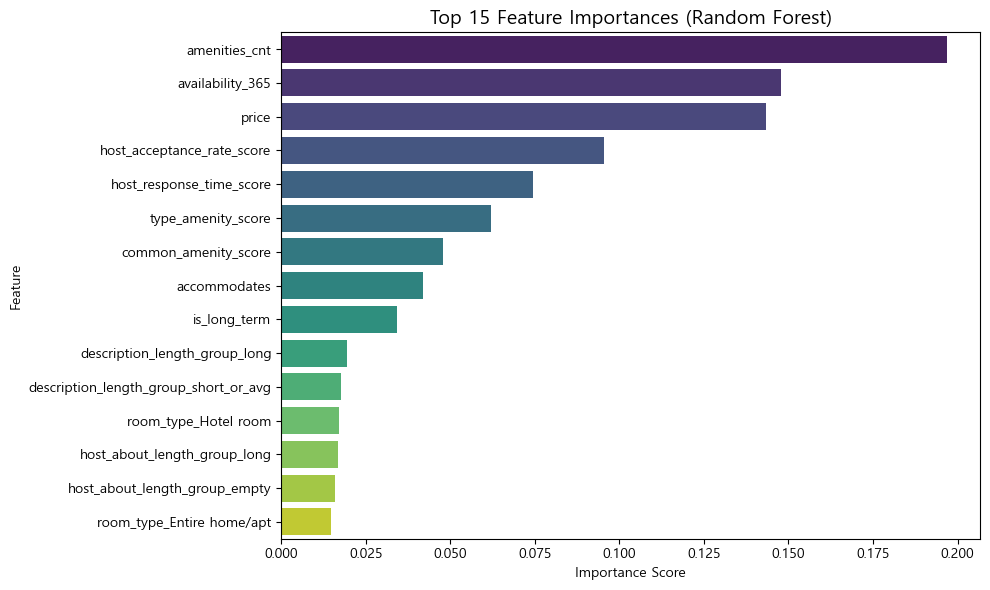

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 변수 중요도 상위 15개 시각화
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title(f'Top {top_n} Feature Importances (Random Forest)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [5]:
# 1. host_response_time → 점수 변환 함수
def response_time_to_score(response_time_str):
    mapping = {
        'within an hour': 4,
        'within a few hours': 3,
        'within a day': 2,
        'a few days or more': 1
    }
    return mapping.get(response_time_str.lower(), 0)  # 기본 0점

# 2. host_response_rate(0~100) → 점수 변환 함수
def response_rate_to_score(rate_percent):
    rate = rate_percent / 100
    if rate <= 0.25:
        return 1
    elif rate <= 0.5:
        return 2
    elif rate <= 0.75:
        return 3
    else:
        return 4

# 3. host_acceptance_rate(0~100) → 점수 변환 함수
def acceptance_rate_to_score(rate_percent):
    rate = rate_percent / 100
    if rate <= 0.25:
        return 1
    elif rate <= 0.5:
        return 2
    elif rate <= 0.75:
        return 3
    else:
        return 4

# 4. amenities 점수 계산 함수
common_amenities = ['Carbon monoxide alarm', 'Essentials', 'Hangers', 'Smoke alarm', 'Wifi']

type_amenity_dict = {
    'high': ['Air conditioning', 'Building staff', 'Elevator', 'Gym', 'Heating', 'Paid parking off premises', 'Shampoo'],
    'low-mid': ['Cleaning products', 'Dining table', 'Exterior security cameras on property', 'Free street parking', 
                'Freezer', 'Laundromat nearby', 'Lock on bedroom door', 'Microwave'],
    'mid': ['Cooking basics', 'Kitchen', 'Oven'],
    'upper-mid': ['Bathtub', 'Cleaning products', 'Cooking basics', 'Dishes and silverware', 'Elevator', 'Freezer']
}

def calc_amenity_scores(amenities_list, room_new_type):
    # 공통 amenity 점수
    common_match = sum(1 for a in amenities_list if a in common_amenities) / len(common_amenities) if common_amenities else 0

    # 타입별 amenity 점수
    type_amenities = type_amenity_dict.get(room_new_type, [])
    type_match = sum(1 for a in amenities_list if a in type_amenities) / len(type_amenities) if type_amenities else 0

    return round(common_match, 3), round(type_match, 3)

# 점수변환 예시 입력값
# 사용자 입력 예시(입력값만 변경)
user_input = {
    'host_response_time': 'within an hour',
    'host_response_rate': 85,  # %
    'host_acceptance_rate': 78,  # %
    'amenities': ['Wifi', 'Essentials', 'Hangers', 'Oven', 'Kitchen'],
    'room_new_type': 'mid'
}

# 점수 계산
response_time_score = response_time_to_score(user_input['host_response_time'])
response_rate_score = response_rate_to_score(user_input['host_response_rate'])
acceptance_rate_score = acceptance_rate_to_score(user_input['host_acceptance_rate'])
common_amenity_score, type_amenity_score = calc_amenity_scores(user_input['amenities'], user_input['room_new_type'])

# 결과 출력
print(f"host_response_time_score: {response_time_score}")
print(f"host_response_rate_score: {response_rate_score}")
print(f"host_acceptance_rate_score: {acceptance_rate_score}")
print(f"common_amenity_score: {common_amenity_score}")
print(f"type_amenity_score: {type_amenity_score}")



# 점수계산 함수값 이용 
# 새로운 데이터 예시 (입력값만 변경)
new_data = pd.DataFrame([{
    'amenities_cnt': 12,
    'availability_365': 200,
    'price': 150,
    'host_about_length_group': 'medium',  # 범주형
    'room_type': 'Entire home/apt',       # 범주형
    'name_length_group': 'short',         # 범주형
    'description_length_group': 'long',   # 범주형
    'host_has_profile_pic': 1,
    'host_response_time_score': 0.9,
    'type_amenity_score': 0.7,
    'common_amenity_score': 0.6,
    'host_acceptance_rate_score': 0.95,
    'host_identity_verified': 1,
    'is_long_term': 0,
    'accommodates': 3
}])

# 모델 학습 때 썼던 컬럼명 저장
train_columns = X_encoded.columns

# 입력 데이터 전처리 함수
def preprocess_input(new_df, train_cols):
    new_encoded = pd.get_dummies(new_df, drop_first=False)
    # 학습 시 없던 컬럼 채우기 (0으로)
    missing_cols = set(train_cols) - set(new_encoded.columns)
    for c in missing_cols:
        new_encoded[c] = 0
    # 순서 맞추기
    new_encoded = new_encoded[train_cols]
    return new_encoded

# 전처리
X_new = preprocess_input(new_data, train_columns)

# 예측
pred = rf.predict(X_new)
proba = rf.predict_proba(X_new)[:, 1]

print("예측 결과 (슈퍼호스트 여부):", pred[0])  # 1이면 슈퍼호스트, 0이면 아님
print("슈퍼호스트 확률:", round(proba[0], 3))




host_response_time_score: 4
host_response_rate_score: 4
host_acceptance_rate_score: 4
common_amenity_score: 0.6
type_amenity_score: 0.667
예측 결과 (슈퍼호스트 여부): 0
슈퍼호스트 확률: 0.121
